In [2]:
from numpy import random
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit, GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [3]:

df = pd.read_csv('CO2 Emissions_Canada.csv', encoding='latin1')
dum = pd.get_dummies(df.Make, dtype= int)

df2 = pd.concat([df, dum], axis= 'columns')

df2

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),...,PORSCHE,RAM,ROLLS-ROYCE,SCION,SMART,SRT,SUBARU,TOYOTA,VOLKSWAGEN,VOLVO
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,...,0,0,0,0,0,0,0,0,0,0
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,...,0,0,0,0,0,0,0,0,0,0
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,...,0,0,0,0,0,0,0,0,0,0
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,...,0,0,0,0,0,0,0,0,0,0
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7380,VOLVO,XC40 T5 AWD,SUV - SMALL,2.0,4,AS8,Z,10.7,7.7,9.4,...,0,0,0,0,0,0,0,0,0,1
7381,VOLVO,XC60 T5 AWD,SUV - SMALL,2.0,4,AS8,Z,11.2,8.3,9.9,...,0,0,0,0,0,0,0,0,0,1
7382,VOLVO,XC60 T6 AWD,SUV - SMALL,2.0,4,AS8,Z,11.7,8.6,10.3,...,0,0,0,0,0,0,0,0,0,1
7383,VOLVO,XC90 T5 AWD,SUV - STANDARD,2.0,4,AS8,Z,11.2,8.3,9.9,...,0,0,0,0,0,0,0,0,0,1


Now I am going to check if the dataset has any null cells. 

In [5]:
sum(df2.isnull().sum())

0

We can see that the dataset has no null value cells in it. 

here I am going to make a bar plot to see which car 'Make' produces the most CO2 emmission(g/km). 

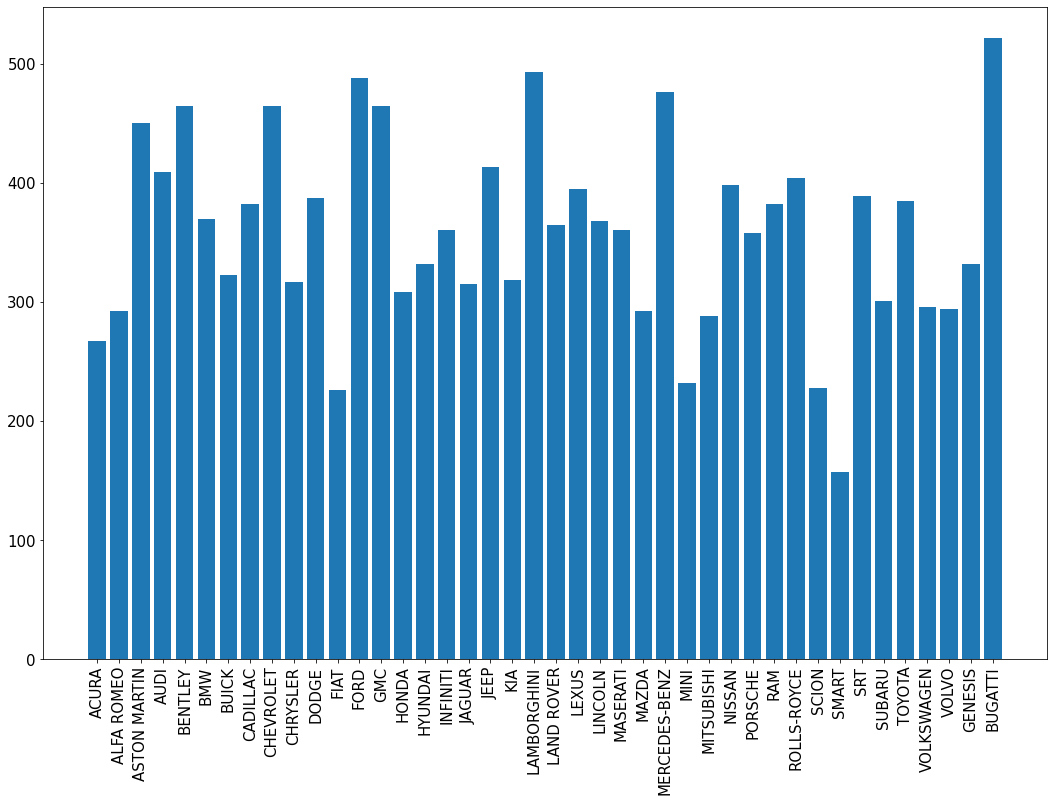

In [13]:
plt.figure(1, [18, 12], frameon= True)
plt.bar(df2['Make'], df['CO2 Emissions(g/km)'])
plt.xticks(rotation= 90)
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 15)
plt.show()

We can see from the plot that 'Bugatti' cars produce the most CO2 emissions. 
this could be due to their high gas consumption.
we are going to explore that by obsering the gas consumption of the cars 
in Liter per 100 km compared to their CO2 emmision.  

Next, I am going to creat best_fit_model function to find the best regrission alogorithim for our data. 
to do so, I am going to use fit then calculate best score. 

Here I am going to see the linear relationship between CO2 Emission(g/km)
and other featurrs like Engine Size(L), Cylenders, ...etc.

In [6]:
def linear_plot(X, y):
    line = np.linspace(0, max(X), len(y))
    model = np.poly1d(np.polyfit(X, y, 4))
    plt.scatter(X, y)
    plt.plot(line, model(line))
    plt.show()

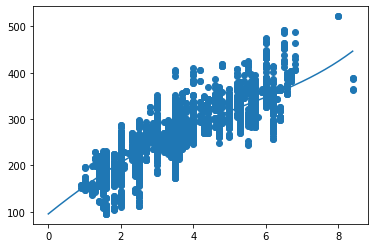

In [7]:
y = df2['CO2 Emissions(g/km)']
linear_plot(df2['Engine Size(L)'], y)

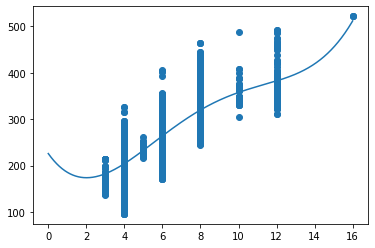

In [8]:
linear_plot(df2.Cylinders, y)

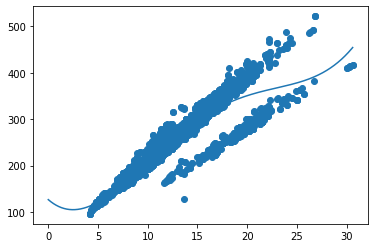

In [9]:
linear_plot(df2['Fuel Consumption City (L/100 km)'], y)

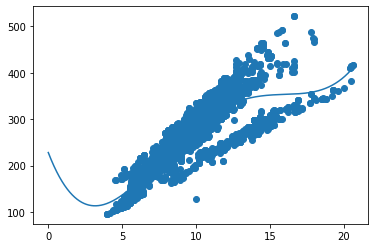

In [10]:
linear_plot(df2['Fuel Consumption Hwy (L/100 km)'], y)

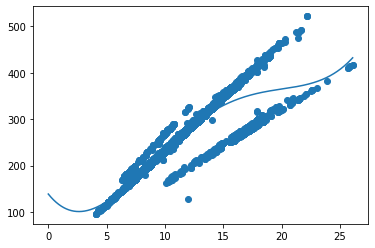

In [11]:
linear_plot(df2['Fuel Consumption Comb (L/100 km)'], y)

From the above plots, we can see that most of the features have a linear correlation with the CO2 emmission(g/km) feature. 

Now, I am going to creatw two dataset (X) has all the predictors(the features we are using to predict the target), And (y) the target. 

In [18]:
X = df2.drop(['Make', 'Model', 'Vehicle Class', 'Transmission',
                  'Fuel Type', 'Fuel Consumption Comb (mpg)',
                  'CO2 Emissions(g/km)'], axis= 'columns')
y = df2['CO2 Emissions(g/km)']

Now, I am going to create a function to predict the best regression algorithim to fit our data(we going to decide that based on the best_score we get from the function). 

In [18]:
def best_fit_model(X, y):
    alg= {
        'lin_reg': {
            'model': LinearRegression(), 
            'params': {
                'positive': [True, False]
            }
        },
        'RFR': {
            'model': RandomForestRegressor(),
            'params': {
                'criterion': ['absolute_error', 'friedman_mse'],
                'max_features': ['sqrt', 'log2']
            }
        },
        'DTR': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion': ['absolute_error', 'friedman_mse'],
                'splitter': ['best', 'random'] 
            }
        }
    }
    score = []
    ss = ShuffleSplit(n_splits= 5, test_size= 0.2, random_state=0)
    for alg_name , config in alg.items(): 
        clf = GridSearchCV(config['model'], config['params'], cv=ss, return_train_score= False,error_score='raise')
        clf.fit(X, y)
        score.append({
            'model_name': alg_name, 
            'score': clf.best_score_,
            'parameters': clf.best_params_
            })
    return(pd.DataFrame(score, columns= ['model_name', 'score', 'parameters']))

best_fit_model(X,y)

,model_name,score,parameters
0,lin_reg,0.892970,{'positive': False}
1,RFR,0.988775,"{'criterion': 'friedman_mse', 'max_features': ..."
2,DTR,0.983431,"{'criterion': 'friedman_mse', 'splitter': 'best'}"


from the best_fit_model dataframe above we can that RandomForestRegressor alogorithim has the highest 
accuracy score among all. therefore it is the one I am going to us to fit our data and then predict CO2 emmission(g/km).

But first, I am going to split the two datasets we have into training and testing datasets. 

In [23]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.3, random_state= 40)


In [24]:
clf = RandomForestRegressor(criterion= 'friedman_mse', max_features= 'sqrt')
clf.fit(X_train,y_train)
score = clf.score(X_test, y_test)
predict = clf.predict(X_train)
predict

acc = metrics.r2_score(y_train, predict)
acc


0.9978507425702405

In [25]:
def predict_CO2(make,eng_size, cyl, FCC, FCH, FCCO):    
    loc_index = np.where(X.columns==make)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = eng_size
    x[1] = cyl
    x[2] = FCC
    x[3] = FCH
    x[4] = FCCO
    if loc_index >= 0:
        x[loc_index] = 1

    return clf.predict([x])[0]

In [1]:

print(predict_CO2('BMW', 8.0, 12, 30.5, 25.5, 27.5))
print(predict_CO2('RAM', 8.0, 12, 30.5, 25.5, 27.5))
print(predict_CO2('PORSCHE', 8.0, 12, 30.5, 25.5, 27.5))

NameError: name 'predict_CO2' is not defined

Karomatov Dovudkhon. December-2023. CO2 Emissions_Canada, Version 1. Retrieved 01-15-2024 from https://www.kaggle.com/datasets/karomatovdovudkhon/co2-emissions-canada.